In [44]:
import numpy as np
import os
import skimage.io as re
import skimage.transform as sktransform
import torch
import tensorflow as tf

In [2]:

from haroun import Data, Model, ConvPool
from haroun.augmentation import augmentation
from haroun.losses import rmse

In [8]:
def load_data():
    path = r"C:\Users\egovridc\Documents\machine_learning\real_and_fake_face"
    images = []
    labels = []
    


    for directory in os.listdir(path):
        data_path = path + "\\" + directory
        
        for im in os.listdir(data_path)[:]:
            image = re.imread(f"{data_path}/{im}")
            image = sktransform.resize(image, (64, 64))
            images.append(image)
            if directory == "training_fake":
                labels.append("fake")
            elif directory == "training_real":
                labels.append("real")
    

    images = np.array(images)
    labels = np.array(labels)

    images, labels = augmentation(images, labels, flip_y=False, flip_x=False, brightness=True)

    return images, labels

In [9]:
classes = {'real': 0, 'fake': 1}
data = Data(loader=load_data(), classes=classes)
data.shape()

Data loaded successfully :)
Images shape: (6123, 64, 64, 3) Labels shape: (6123,)



In [23]:
data

In [10]:
data.stat()

{'real': 3243, 'fake': 2880}


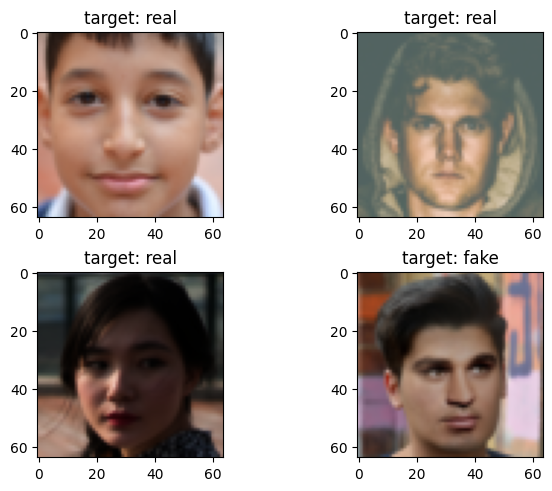

In [11]:
data.show()

In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
data.dataset(split_size=0.05, shuffle=True, random_state=42,
             images_format=torch.float32, labels_format=torch.float32,
             permute=True, one_hot=True, device=device)

Train tensor shape: torch.Size([5816, 3, 64, 64]), torch.Size([5816, 2])
Test tensor shape: torch.Size([153, 3, 64, 64]), torch.Size([153, 2])
Validation tensor shape: torch.Size([154, 3, 64, 64]), torch.Size([154, 2])

Dataset generated successfully :)


In [13]:
class Network(torch.nn.Module):

    def __init__(self):
        super(Network, self).__init__()
        self.input_norm = torch.nn.BatchNorm2d(3, affine=False)
        self.layer1 = ConvPool(in_features=3, out_features=8)
        self.layer2 = ConvPool(in_features=8, out_features=16)
        self.layer3 = ConvPool(in_features=16, out_features=32)
        self.layer4 = ConvPool(in_features=32, out_features=64)
        self.layer5 = ConvPool(in_features=64, out_features=128)
        self.layer6 = ConvPool(in_features=128, out_features=256)
        
        

        self.net = torch.nn.Sequential(self.layer1, self.layer2, self.layer3, 
                                       self.layer4, self.layer5, self.layer6)
            
        
        self.fc1 = torch.nn.Linear(in_features=256, out_features=128)
        self.bn1 = torch.nn.BatchNorm1d(128)
        
        self.fc2 = torch.nn.Linear(in_features=128, out_features=32)
        self.bn2 = torch.nn.BatchNorm1d(32)

        self.fc3 = torch.nn.Linear(in_features=32, out_features=8)
        self.bn3 = torch.nn.BatchNorm1d(8)

        self.fc4 = torch.nn.Linear(in_features=8, out_features=2)


        self.lin = torch.nn.Sequential(self.fc1, self.bn1, self.fc2, self.bn2,
                                       self.fc3, self.bn3, self.fc4)  


    def forward(self, X: torch.Tensor) -> torch.Tensor:
        X = self.input_norm(X)
        X = self.net(X)
        X = X.reshape(X.size(0), -1)
        X = self.lin(X)
        X = torch.nn.functional.elu(X, alpha=1.0, inplace=False)
        return X

In [14]:
net = Network()
AntiSpoofClassifier = Model(net, "adam", rmse, device)
AntiSpoofClassifier.train(train_data=(data.train_inputs, data.train_outputs),
                          val_data=(data.val_inputs, data.val_outputs),
                          epochs=24, patience=20, batch_size=100, learning_rate=1.0E-3)

Model initialized succssefully :)

Train loop:

	Epoch: 1/24,  Train Loss: 0.0773,  Val Loss: 0.0803
	Epoch: 2/24,  Train Loss: 0.0667,  Val Loss: 0.0821 - No improvement -> Remaining patience: 19
	Epoch: 3/24,  Train Loss: 0.0592,  Val Loss: 0.0713
	Epoch: 4/24,  Train Loss: 0.0511,  Val Loss: 0.0642
	Epoch: 5/24,  Train Loss: 0.0429,  Val Loss: 0.066 - No improvement -> Remaining patience: 19
	Epoch: 6/24,  Train Loss: 0.034,  Val Loss: 0.057
	Epoch: 7/24,  Train Loss: 0.0278,  Val Loss: 0.0487
	Epoch: 8/24,  Train Loss: 0.0232,  Val Loss: 0.0429
	Epoch: 9/24,  Train Loss: 0.0201,  Val Loss: 0.0431 - No improvement -> Remaining patience: 19
	Epoch: 10/24,  Train Loss: 0.0205,  Val Loss: 0.0455 - No improvement -> Remaining patience: 18
	Epoch: 11/24,  Train Loss: 0.0195,  Val Loss: 0.0412
	Epoch: 12/24,  Train Loss: 0.0199,  Val Loss: 0.049 - No improvement -> Remaining patience: 19
	Epoch: 13/24,  Train Loss: 0.0194,  Val Loss: 0.0421 - No improvement -> Remaining patience: 18
	Epoc

In [15]:
AntiSpoofClassifier.evaluate(test_data=(data.test_inputs, data.test_outputs))



Test accuracy:97.4%
Correct predictions: 149, Wrong predictions: 4


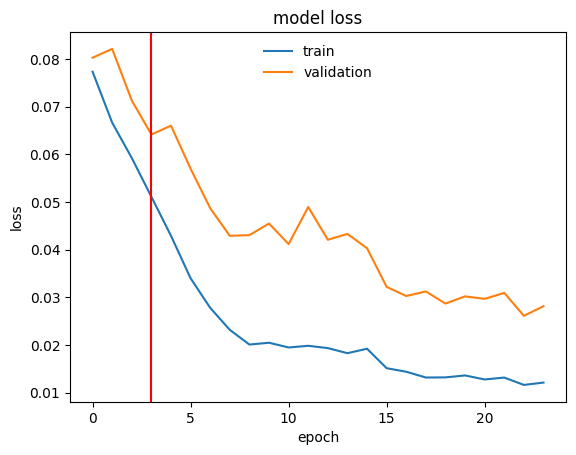


Checkpoint saved successfully :)


In [16]:
AntiSpoofClassifier.plot()
AntiSpoofClassifier.save(path="./", checkpoint_name="module")

In [17]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Network()
AntiSpoofClassifier = Model(net, "adam", rmse, device)

Model initialized succssefully :)



In [33]:
model.load_state_dict(torch.load(r"C:\Users\egovridc\Documents\machine_learning\module.pth"))


<All keys matched successfully>

In [71]:
from torchvision import transforms
import tensorflow as tf 
from PIL import Image

trans = transforms.Compose([transforms.ToTensor()])
demo = Image.open(r"C:\Users\egovridc\Documents\machine_learning\real_and_fake_face\training_fake\hard_116_1101.jpg") 
demo = demo.resize((64, 64))
demo_img = trans(demo)
demo_img = demo_img.unsqueeze(0)


In [72]:
model.eval()
output = model(demo_img)

In [73]:
output.max(1)

torch.return_types.max(
values=tensor([0.9132], grad_fn=<MaxBackward0>),
indices=tensor([1]))